In [1]:
#import modules
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


pd.options.display.max_columns=999
pd.options.display.max_rows=3000

from openpyxl.workbook import Workbook

In [2]:
data_file = pd.read_excel('Collections Case Study Data.xlsx', sheet_name=None)

## Model Data Cleaning 

In [3]:
data_file.keys()

dict_keys(['Loan Details', 'Loan_Status_MartoMay', 'Loan_Status_AprtoJun', 'Historical 6 Months Details', 'Loan_ID mapping', 'Call Details'])

In [4]:
df = data_file

In [5]:
#creates stratums for data based on month
mar_data = df['Loan_Status_MartoMay'].loc[df['Loan_Status_MartoMay']['Month'] == 'March']
apr_data = df['Loan_Status_MartoMay'].loc[df['Loan_Status_MartoMay']['Month'] == 'April']
may_data = df['Loan_Status_MartoMay'].loc[df['Loan_Status_MartoMay']['Month'] == 'May']
marapr_data = df['Loan_Status_AprtoJun'].loc[df['Loan_Status_AprtoJun']['Month'] == 'April']
aprmay_data = df['Loan_Status_AprtoJun'].loc[df['Loan_Status_AprtoJun']['Month'] == 'May']
mayjun_data = df['Loan_Status_AprtoJun'].loc[df['Loan_Status_AprtoJun']['Month'] == 'June']

In [6]:
#QC checking to see if our assumption is correct
print(len(mar_data) == len(marapr_data))
print(len(apr_data) == len(aprmay_data))
print(len(may_data) == len(mayjun_data))

True
True
True


In [7]:
#creates stratums for each month with performance in the following month
mar_data1 = pd.merge(mar_data, marapr_data, how='left', on='Loan_id', suffixes=('_mar', '_marapr'))
apr_data1 = pd.merge(apr_data, aprmay_data, how='left', on='Loan_id', suffixes=('_apr', '_aprmay'))
may_data1 = pd.merge(may_data, mayjun_data, how='left', on='Loan_id', suffixes=('_may', '_mayjun'))

In [8]:
#merges monthly data into one dataframe
data1 = pd.merge(mar_data1, apr_data1, how='outer', on='Loan_id')
data1 = pd.merge(data1, may_data1, how='outer', on='Loan_id')

In [9]:
print(mar_data1.shape)
print(apr_data1.shape)
print(may_data1.shape)
print(data1.shape)

(24575, 13)
(27079, 13)
(29115, 13)
(40339, 37)


In [10]:
data1.head()

,Loan_id,Bucket_mar,TENURE_mar,PRINBALANCE_mar,Months on Books_mar,Sanctioned Amount_mar,Month_mar,Bucket_marapr,PRINBALANCE_marapr,TENURE_marapr,Months on Books_marapr,Sanctioned Amount_marapr,Month_marapr,Bucket_apr,TENURE_apr,PRINBALANCE_apr,Months on Books_apr,Sanctioned Amount_apr,Month_apr,Bucket_aprmay,PRINBALANCE_aprmay,TENURE_aprmay,Months on Books_aprmay,Sanctioned Amount_aprmay,Month_aprmay,Bucket_may,TENURE_may,PRINBALANCE_may,Months on Books_may,Sanctioned Amount_may,Month_may,Bucket_mayjun,PRINBALANCE_mayjun,TENURE_mayjun,Months on Books_mayjun,Sanctioned Amount_mayjun,Month_mayjun
0,A205346000,TB0,36.0,3693500.0,33.0,22000000.0,March,TB1,1332100.0,36.0,34.0,22000000.0,April,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A675851816,TB0,48.0,24353700.0,30.0,40000000.0,March,TB1,20875500.0,48.0,31.0,40000000.0,April,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A260852240,TB0,48.0,42514900.0,24.0,60000000.0,March,TB1,37947922.5,48.0,25.0,60000000.0,April,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A374402177,TB0,36.0,12290300.0,19.0,20000000.0,March,TB0,11214900.0,36.0,20.0,20000000.0,April,TB0,36.0,11214900.0,20.0,20000000.0,April,TB0,10639500.0,36.0,21.0,20000000.0,May,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A211889361,TB0,36.0,9396700.0,25.0,22000000.0,March,TB0,8666200.0,36.0,26.0,22000000.0,April,TB0,36.0,8666200.0,26.0,22000000.0,April,TB1,8666200.0,36.0,27.0,22000000.0,May,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data1.columns

Index(['Loan_id', 'Bucket_mar', 'TENURE_mar', 'PRINBALANCE_mar',
       'Months on Books_mar', 'Sanctioned Amount_mar', 'Month_mar',
       'Bucket_marapr', 'PRINBALANCE_marapr', 'TENURE_marapr',
       'Months on Books_marapr', 'Sanctioned Amount_marapr', 'Month_marapr',
       'Bucket_apr', 'TENURE_apr', 'PRINBALANCE_apr', 'Months on Books_apr',
       'Sanctioned Amount_apr', 'Month_apr', 'Bucket_aprmay',
       'PRINBALANCE_aprmay', 'TENURE_aprmay', 'Months on Books_aprmay',
       'Sanctioned Amount_aprmay', 'Month_aprmay', 'Bucket_may', 'TENURE_may',
       'PRINBALANCE_may', 'Months on Books_may', 'Sanctioned Amount_may',
       'Month_may', 'Bucket_mayjun', 'PRINBALANCE_mayjun', 'TENURE_mayjun',
       'Months on Books_mayjun', 'Sanctioned Amount_mayjun', 'Month_mayjun'],
      dtype='object')

In [12]:
data1 = data1.drop(columns=['Month_mar', 'TENURE_marapr', 'Sanctioned Amount_marapr', 'Month_marapr', 'TENURE_apr', 'Sanctioned Amount_apr','Month_apr', 'TENURE_aprmay', 'Sanctioned Amount_aprmay', 'Month_aprmay', 'TENURE_may', 'Sanctioned Amount_may', 'Month_may', 'TENURE_mayjun', 'Sanctioned Amount_mayjun', 'Month_mayjun'])

In [13]:
data1.describe()

,TENURE_mar,PRINBALANCE_mar,Months on Books_mar,Sanctioned Amount_mar,PRINBALANCE_marapr,Months on Books_marapr,PRINBALANCE_apr,Months on Books_apr,PRINBALANCE_aprmay,Months on Books_aprmay,PRINBALANCE_may,Months on Books_may,PRINBALANCE_mayjun,Months on Books_mayjun
count,24575.000000,2.457500e+04,24575.000000,2.457500e+04,2.457500e+04,24575.000000,2.707900e+04,27079.000000,2.707900e+04,27079.000000,2.911500e+04,29115.000000,2.911500e+04,29115.000000
mean,41.832838,3.368172e+07,15.600895,4.603559e+07,3.183383e+07,16.600895,3.340031e+07,15.773847,3.157736e+07,16.773847,3.415342e+07,15.400996,3.231523e+07,16.400996
std,7.599259,2.397062e+07,10.692061,2.586228e+07,2.367301e+07,10.692061,2.364095e+07,10.643053,2.335223e+07,10.643053,2.497425e+07,10.549727,2.467654e+07,10.549727
min,12.000000,4.090000e+05,0.000000,1.000000e+07,2.000000e+02,1.000000,7.470000e+04,0.000000,1.000000e+03,1.000000,2.372000e+05,0.000000,2.000000e+02,1.000000
25%,36.000000,1.762650e+07,6.000000,3.000000e+07,1.597412e+07,7.000000,1.757270e+07,7.000000,1.592710e+07,8.000000,1.807675e+07,6.000000,1.641180e+07,7.000000
50%,48.000000,2.906860e+07,14.000000,4.000000e+07,2.757780e+07,15.000000,2.893120e+07,15.000000,2.740140e+07,16.000000,2.940660e+07,14.000000,2.798320e+07,15.000000
75%,48.000000,4.406620e+07,23.000000,5.500000e+07,4.230300e+07,24.000000,4.370955e+07,23.000000,4.205315e+07,24.000000,4.434225e+07,22.000000,4.268020e+07,23.000000
max,239.000000,3.753802e+08,74.000000,4.200000e+08,3.732658e+08,75.000000,3.743314e+08,78.000000,3.721831e+08,79.000000,1.137036e+09,84.000000,1.131137e+09,85.000000


In [14]:
data2=data1

In [15]:
data2.head()

,Loan_id,Bucket_mar,TENURE_mar,PRINBALANCE_mar,Months on Books_mar,Sanctioned Amount_mar,Bucket_marapr,PRINBALANCE_marapr,Months on Books_marapr,Bucket_apr,PRINBALANCE_apr,Months on Books_apr,Bucket_aprmay,PRINBALANCE_aprmay,Months on Books_aprmay,Bucket_may,PRINBALANCE_may,Months on Books_may,Bucket_mayjun,PRINBALANCE_mayjun,Months on Books_mayjun
0,A205346000,TB0,36.0,3693500.0,33.0,22000000.0,TB1,1332100.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A675851816,TB0,48.0,24353700.0,30.0,40000000.0,TB1,20875500.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A260852240,TB0,48.0,42514900.0,24.0,60000000.0,TB1,37947922.5,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A374402177,TB0,36.0,12290300.0,19.0,20000000.0,TB0,11214900.0,20.0,TB0,11214900.0,20.0,TB0,10639500.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
4,A211889361,TB0,36.0,9396700.0,25.0,22000000.0,TB0,8666200.0,26.0,TB0,8666200.0,26.0,TB1,8666200.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:

data2['RF1'] = np.where(data2['Bucket_mar']=='TB0', 1, 0)
data2['RF2'] = np.where((data2['Bucket_apr']=='TB0')|(data2['Bucket_apr']=='TB1'), 1, 0)
data2['RF3'] = np.where((data2['Bucket_may']=='TB0')|(data2['Bucket_may']=='TB1'), 1, 0)
data2['RF4'] = np.where((data2['Bucket_mayjun']=='TB0')|(data2['Bucket_mayjun']=='TB1'), 1, 0)

In [34]:
# data2['RB2'] = np.where((data2['Bucket_apr']=='TB0')&(data2['Bucket_mar']=='TB0'), 1, 0)
# data2['RB3'] = np.where(((data2['Bucket_may']=='Nan')&(data2['Bucket_apr']=='TB0')|(data2['Bucket_may']=='REGULAR')&(data2['Bucket_apr']=='TB0')|(data2['Bucket_may']=='TB0')&(data2['Bucket_apr']=='TB1')
#                         ), 1, 0)
# data2['RB4'] = np.where(((data2['Bucket_may31']=='Nan')&(data2['Bucket_may01']=='TB0')
#                          |(data2['Bucket_may31']=='REGULAR')&(data2['Bucket_may01']=='TB0')
#                         |(data2['Bucket_may31']=='TB0')&(data2['Bucket_may01']=='TB1')
#                         ), 1, 0)

In [17]:
data2['RF4'].value_counts()

0    38309
1     2030
Name: RF4, dtype: int64

In [18]:
data2.head()

,Loan_id,Bucket_mar,TENURE_mar,PRINBALANCE_mar,Months on Books_mar,Sanctioned Amount_mar,Bucket_marapr,PRINBALANCE_marapr,Months on Books_marapr,Bucket_apr,PRINBALANCE_apr,Months on Books_apr,Bucket_aprmay,PRINBALANCE_aprmay,Months on Books_aprmay,Bucket_may,PRINBALANCE_may,Months on Books_may,Bucket_mayjun,PRINBALANCE_mayjun,Months on Books_mayjun,RF1,RF2,RF3,RF4
0,A205346000,TB0,36.0,3693500.0,33.0,22000000.0,TB1,1332100.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
1,A675851816,TB0,48.0,24353700.0,30.0,40000000.0,TB1,20875500.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
2,A260852240,TB0,48.0,42514900.0,24.0,60000000.0,TB1,37947922.5,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
3,A374402177,TB0,36.0,12290300.0,19.0,20000000.0,TB0,11214900.0,20.0,TB0,11214900.0,20.0,TB0,10639500.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0
4,A211889361,TB0,36.0,9396700.0,25.0,22000000.0,TB0,8666200.0,26.0,TB0,8666200.0,26.0,TB1,8666200.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0


In [19]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40339 entries, 0 to 40338
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Loan_id                 40339 non-null  object 
 1   Bucket_mar              24575 non-null  object 
 2   TENURE_mar              24575 non-null  float64
 3   PRINBALANCE_mar         24575 non-null  float64
 4   Months on Books_mar     24575 non-null  float64
 5   Sanctioned Amount_mar   24575 non-null  float64
 6   Bucket_marapr           24575 non-null  object 
 7   PRINBALANCE_marapr      24575 non-null  float64
 8   Months on Books_marapr  24575 non-null  float64
 9   Bucket_apr              27079 non-null  object 
 10  PRINBALANCE_apr         27079 non-null  float64
 11  Months on Books_apr     27079 non-null  float64
 12  Bucket_aprmay           27079 non-null  object 
 13  PRINBALANCE_aprmay      27079 non-null  float64
 14  Months on Books_aprmay  27079 non-null

In [20]:
data2.columns

Index(['Loan_id', 'Bucket_mar', 'TENURE_mar', 'PRINBALANCE_mar',
       'Months on Books_mar', 'Sanctioned Amount_mar', 'Bucket_marapr',
       'PRINBALANCE_marapr', 'Months on Books_marapr', 'Bucket_apr',
       'PRINBALANCE_apr', 'Months on Books_apr', 'Bucket_aprmay',
       'PRINBALANCE_aprmay', 'Months on Books_aprmay', 'Bucket_may',
       'PRINBALANCE_may', 'Months on Books_may', 'Bucket_mayjun',
       'PRINBALANCE_mayjun', 'Months on Books_mayjun', 'RF1', 'RF2', 'RF3',
       'RF4'],
      dtype='object')

### TB0 Data 

In [21]:
data_TB0 = pd.DataFrame(df['Loan_Status_MartoMay'])
data_TB0 = data_TB0.drop_duplicates(subset ="Loan_id", keep = 'first', inplace = False) 
data_TB0 = data_TB0.drop(columns=['TENURE', 'Sanctioned Amount','Month',  'Bucket'])
data_TB0.info() 
                               

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40339 entries, 0 to 80759
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Loan_id          40339 non-null  object 
 1   PRINBALANCE      40339 non-null  float64
 2   Months on Books  40339 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


### Historical Data Prep

In [22]:
#cleaning/processing 6 month data 
data_6m = pd.DataFrame(df['Historical 6 Months Details'])
data_6m = data_6m.drop_duplicates(subset ="Loan_id", keep = 'first', inplace = False) 
data_6m = data_6m.drop(columns=['rollf', 'Month'])
data_6m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40339 entries, 0 to 80759
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Loan_id           40339 non-null  object
 1   paidcure          40339 non-null  int64 
 2   paiduncure        40339 non-null  int64 
 3   unpaid            40339 non-null  int64 
 4   rollb             40339 non-null  int64 
 5   num6mosdel        40339 non-null  int64 
 6   num3mosdel        40339 non-null  int64 
 7   num6mosdel_2plus  40339 non-null  int64 
 8   num3mosdel_2plus  40339 non-null  int64 
 9   max6del           40339 non-null  int64 
 10  max3del           40339 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 3.7+ MB


### Call Data Prep

In [23]:
#assigns 'Call Detail' table to dataframe
call_data = df['Call Details']
call_data.tail()

,month,Application_Id,Login_ID,Right_Party_Contact,Promise_to_pay,total_contacts
79609,5,MX-999897229,AGNT19,0,0,2
79610,5,MX-999911711,AGNT6,0,0,1
79611,5,MX-999978990,AGNT43,2,0,2
79612,5,MX-999980626,AGNT21,1,1,1
79613,5,MX-999985403,AGNT19,5,1,6


In [24]:
#groups call data by id and then aggregates
month_table = call_data.groupby(['Application_Id']).aggregate({'month':'nunique', 'Right_Party_Contact':'sum', 'Promise_to_pay':'sum', 'total_contacts':'sum'})

#calculates Right Party Contacts (RPC) rate and Percentage of outbound calls resulting in Promise to Pay (PTP)
# month_table['avg_intensity'] = round(month_table['total_contacts'] / month_table['month'], 3)
month_table['RPC_rate'] = round(month_table['Right_Party_Contact'] / month_table['total_contacts'], 3)
month_table['PTP_rate'] = round(month_table['Promise_to_pay'] / month_table['total_contacts'], 3)
month_table.rename(columns={'month':'month_count'}, inplace=True)



In [25]:
call_data = pd.merge(df['Loan_ID mapping'], month_table, how='outer', left_on='Application_id', right_on='Application_Id')

In [26]:
call_data.fillna(0, inplace=True)
valid = len(month_table)
missing = len(call_data[call_data['total_contacts'].isnull()])
call_data[call_data['total_contacts'].isnull()]

,Loanid,Application_id,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate


In [27]:

call_data.rename(columns = {call_data.columns[0]: 'Loan_id'}, inplace = True)

In [28]:
call_data.head()

,Loan_id,Application_id,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate
0,A987633031,MX-100040250,1.0,5.0,2.0,21.0,0.238,0.095
1,A145720684,MX-10005082,1.0,0.0,0.0,2.0,0.000,0.000
2,A730581847,MX-100062359,1.0,1.0,1.0,1.0,1.000,1.000
3,A134412216,MX-100095892,1.0,1.0,0.0,2.0,0.500,0.000
4,A897161619,MX-100116696,3.0,5.0,2.0,10.0,0.500,0.200


## Target Prep

In [29]:
data2.head()

,Loan_id,Bucket_mar,TENURE_mar,PRINBALANCE_mar,Months on Books_mar,Sanctioned Amount_mar,Bucket_marapr,PRINBALANCE_marapr,Months on Books_marapr,Bucket_apr,PRINBALANCE_apr,Months on Books_apr,Bucket_aprmay,PRINBALANCE_aprmay,Months on Books_aprmay,Bucket_may,PRINBALANCE_may,Months on Books_may,Bucket_mayjun,PRINBALANCE_mayjun,Months on Books_mayjun,RF1,RF2,RF3,RF4
0,A205346000,TB0,36.0,3693500.0,33.0,22000000.0,TB1,1332100.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
1,A675851816,TB0,48.0,24353700.0,30.0,40000000.0,TB1,20875500.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
2,A260852240,TB0,48.0,42514900.0,24.0,60000000.0,TB1,37947922.5,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
3,A374402177,TB0,36.0,12290300.0,19.0,20000000.0,TB0,11214900.0,20.0,TB0,11214900.0,20.0,TB0,10639500.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0
4,A211889361,TB0,36.0,9396700.0,25.0,22000000.0,TB0,8666200.0,26.0,TB0,8666200.0,26.0,TB1,8666200.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0


In [30]:
target_prep = data2.drop(columns=['Bucket_mar', 'TENURE_mar', 'PRINBALANCE_mar', 'Months on Books_mar', 'Sanctioned Amount_mar', 'Bucket_marapr', 'PRINBALANCE_marapr', 'Months on Books_marapr', 'Bucket_apr', 'PRINBALANCE_apr', 'Months on Books_apr', 'Bucket_aprmay', 'PRINBALANCE_aprmay', 'Months on Books_aprmay', 'Bucket_may', 'PRINBALANCE_may', 'Months on Books_may', 'Bucket_mayjun', 'PRINBALANCE_mayjun', 'Months on Books_mayjun',
                               ])

In [31]:
target_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40339 entries, 0 to 40338
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Loan_id  40339 non-null  object
 1   RF1      40339 non-null  int64 
 2   RF2      40339 non-null  int64 
 3   RF3      40339 non-null  int64 
 4   RF4      40339 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.1+ MB


In [32]:

target_prep['RF_sum'] = target_prep['RF1'] + target_prep['RF2'] +target_prep['RF3'] + target_prep['RF4']
target_prep['target'] = target_prep['RF_sum'].apply(lambda x: 1 if x >1 else 0)
target_prep.columns

Index(['Loan_id', 'RF1', 'RF2', 'RF3', 'RF4', 'RF_sum', 'target'], dtype='object')

In [36]:
target = target_prep.drop(columns=[ 'RF1', 'RF2', 'RF3', 'RF4', 'RF_sum'])

In [37]:
target.head()

,Loan_id,target
0,A205346000,0
1,A675851816,0
2,A260852240,0
3,A374402177,1
4,A211889361,1


### Features Combined

In [38]:
dataframe = pd.merge(data_TB0, df['Loan Details'], how='left', on='Loan_id')


In [39]:
dataframe = pd.merge(dataframe, data_6m, how='left', on='Loan_id')

In [40]:
dataframe = pd.merge(dataframe, call_data, how='left', on='Loan_id')

In [41]:
dataframe = pd.merge(dataframe, target, how='left', on='Loan_id')

In [42]:
dataframe = dataframe.drop(columns=[ 'Loan_id','Application_id','rollb'])

In [43]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40339 entries, 0 to 40338
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRINBALANCE           40339 non-null  float64
 1   Months on Books       40339 non-null  int64  
 2   Debt_to_burden_Ratio  40339 non-null  float64
 3   total_income          40339 non-null  float64
 4   TENURE                40339 non-null  int64  
 5   Sanctioned Amount     40339 non-null  int64  
 6   paidcure              40339 non-null  int64  
 7   paiduncure            40339 non-null  int64  
 8   unpaid                40339 non-null  int64  
 9   num6mosdel            40339 non-null  int64  
 10  num3mosdel            40339 non-null  int64  
 11  num6mosdel_2plus      40339 non-null  int64  
 12  num3mosdel_2plus      40339 non-null  int64  
 13  max6del               40339 non-null  int64  
 14  max3del               40339 non-null  int64  
 15  month_count        

In [44]:
dataframe.head()

,PRINBALANCE,Months on Books,Debt_to_burden_Ratio,total_income,TENURE,Sanctioned Amount,paidcure,paiduncure,unpaid,num6mosdel,num3mosdel,num6mosdel_2plus,num3mosdel_2plus,max6del,max3del,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate,target
0,10539100.0,37,0.244840,5000000.0,48,30000000,2,1,3,5,2,4,2,5,5,2.0,5.0,0.0,16.0,0.312,0.0,1
1,3693500.0,33,0.247458,4199908.0,36,22000000,2,1,3,6,3,6,3,4,4,0.0,0.0,0.0,0.0,0.000,0.0,0
2,24353700.0,30,0.149219,9887482.0,48,40000000,2,1,3,4,3,3,3,4,4,1.0,1.0,0.0,1.0,1.000,0.0,0
3,4441700.0,30,0.178700,5000000.0,36,20000000,2,1,3,4,2,3,2,4,4,1.0,0.0,0.0,1.0,0.000,0.0,0
4,20002300.0,19,0.212669,6105249.0,36,30000000,2,2,2,5,3,2,2,3,3,0.0,0.0,0.0,0.0,0.000,0.0,0


In [48]:
dataframe['target'].value_counts()

1    25885
0    14454
Name: target, dtype: int64

In [50]:
len(dataframe['target'])

40339

In [54]:
dataframe.describe()

,PRINBALANCE,Months on Books,Debt_to_burden_Ratio,total_income,TENURE,Sanctioned Amount,paidcure,paiduncure,unpaid,num6mosdel,num3mosdel,num6mosdel_2plus,num3mosdel_2plus,max6del,max3del,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate,target
count,4.033900e+04,40339.000000,40339.000000,4.033900e+04,40339.000000,4.033900e+04,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000,40339.000000
mean,3.389235e+07,15.375914,0.288089,7.975965e+06,41.596445,4.616752e+07,5.166811,0.034929,0.087657,0.240289,0.182032,0.011800,0.006247,0.159548,0.149409,1.857384,6.343018,2.208830,21.699993,0.440444,0.197430,0.641687
std,2.507444e+07,10.947705,0.158125,3.065198e+07,7.859246,2.682744e+07,1.597513,0.200264,0.300150,0.750624,0.499401,0.187384,0.100870,0.392463,0.376056,0.944077,10.807385,2.813729,36.832550,0.322395,0.254779,0.479511
min,2.372000e+05,0.000000,0.000192,8.000000e+05,12.000000,1.000000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.762100e+07,6.000000,0.227182,5.715942e+06,36.000000,3.000000e+07,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.188000,0.000000,0.000000
50%,2.924670e+07,14.000000,0.261264,7.000000e+06,48.000000,4.000000e+07,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,1.000000,8.000000,0.387000,0.110000,1.000000
75%,4.439438e+07,23.000000,0.327515,8.514182e+06,48.000000,5.500000e+07,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,3.000000,24.000000,0.667000,0.286000,1.000000
max,1.137036e+09,84.000000,11.111200,6.100000e+09,240.000000,1.300000e+09,6.000000,3.000000,3.000000,6.000000,3.000000,6.000000,3.000000,5.000000,5.000000,3.000000,651.000000,43.000000,662.000000,1.000000,1.000000,1.000000


## Model

In [45]:
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [55]:
X= dataframe.drop(columns=['target'])
y= dataframe['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [57]:
predictions = lr.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.6455078125


In [56]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
from sklearn.model_selection import cross_val_score
import numpy as np
lr = LogisticRegression()
scores = cross_val_score(lr, X, y, cv=10)
accuracy = scores.mean()
print(scores)
print(accuracy)

[0.64179474 0.64179474 0.64179474 0.64179474 0.64179474 0.64154685
 0.64154685 0.64154685 0.64154685 0.64170593]
0.6416867056501266


In [65]:
X_train.describe()

,PRINBALANCE,Months on Books,Debt_to_burden_Ratio,total_income,TENURE,Sanctioned Amount,paidcure,paiduncure,unpaid,num6mosdel,num3mosdel,num6mosdel_2plus,num3mosdel_2plus,max6del,max3del,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate,PRINBALANCE_scaled,Months on Books_scaled,Debt_to_burden_Ratio_scaled,total_income_scaled,TENURE_scaled,Sanctioned Amount_scaled,paidcure_scaled,paiduncure_scaled,unpaid_scaled,num6mosdel_scaled,num3mosdel_scaled,num6mosdel_2plus_scaled,num3mosdel_2plus_scaled,max6del_scaled,max3del_scaled,month_count_scaled,Right_Party_Contact_scaled,Promise_to_pay_scaled,total_contacts_scaled,RPC_rate_scaled,PTP_rate_scaled
count,2.702700e+04,27027.000000,27027.000000,2.702700e+04,27027.000000,2.702700e+04,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000
mean,3.393782e+07,15.363414,0.288834,8.044650e+06,41.547675,4.616927e+07,5.165945,0.034928,0.087431,0.237207,0.179561,0.011840,0.006401,0.157990,0.147519,1.852999,6.322529,2.202057,21.660414,0.440406,0.198697,0.086987,0.202150,0.025978,0.001188,0.129595,0.086117,0.860991,0.011643,0.029144,0.039535,0.059854,0.001973,0.002134,0.031598,0.029504,0.617666,0.023159,0.051211,0.043062,0.440406,0.198697
std,2.477716e+07,10.921385,0.172073,3.727157e+07,7.780972,2.634520e+07,1.601273,0.200922,0.301725,0.745947,0.495879,0.188492,0.104635,0.392588,0.374719,0.946214,10.392781,2.818399,36.712891,0.322662,0.256840,0.063966,0.143702,0.015487,0.006111,0.034127,0.062727,0.266879,0.066974,0.100575,0.124325,0.165293,0.031415,0.034878,0.078518,0.074944,0.315405,0.038069,0.065544,0.072988,0.322662,0.256840
min,2.438000e+05,0.000000,0.000192,8.000000e+05,12.000000,1.000000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.763915e+07,6.000000,0.227115,5.700000e+06,36.000000,3.000000e+07,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.188000,0.000000,0.044909,0.078947,0.020423,0.000803,0.105263,0.047619,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.003663,0.000000,0.005964,0.188000,0.000000
50%,2.911000e+07,14.000000,0.260454,7.000000e+06,48.000000,4.000000e+07,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,1.000000,8.000000,0.386000,0.108000,0.074523,0.184211,0.023424,0.001017,0.157895,0.071429,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.010989,0.023256,0.015905,0.386000,0.108000
75%,4.450280e+07,23.000000,0.327860,8.515647e+06,48.000000,5.500000e+07,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,3.000000,24.000000,0.667000,0.286000,0.114262,0.302632,0.029490,0.001265,0.157895,0.107143,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.029304,0.069767,0.047714,0.667000,0.286000
max,3.875910e+08,76.000000,11.111200,6.100000e+09,240.000000,4.300000e+08,6.000000,3.000000,3.000000,6.000000,3.000000,6.000000,3.000000,5.000000,5.000000,3.000000,273.000000,43.000000,503.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [63]:
from sklearn.preprocessing import minmax_scale
columns = X_train.columns
for c in columns:
    X_train[c + '_scaled'] = minmax_scale(X_train[c])
    X_test[c + '_scaled'] = minmax_scale(X_test[c])

In [64]:
X_train.head()

,PRINBALANCE,Months on Books,Debt_to_burden_Ratio,total_income,TENURE,Sanctioned Amount,paidcure,paiduncure,unpaid,num6mosdel,num3mosdel,num6mosdel_2plus,num3mosdel_2plus,max6del,max3del,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate,PRINBALANCE_scaled,Months on Books_scaled,Debt_to_burden_Ratio_scaled,total_income_scaled,TENURE_scaled,Sanctioned Amount_scaled,paidcure_scaled,paiduncure_scaled,unpaid_scaled,num6mosdel_scaled,num3mosdel_scaled,num6mosdel_2plus_scaled,num3mosdel_2plus_scaled,max6del_scaled,max3del_scaled,month_count_scaled,Right_Party_Contact_scaled,Promise_to_pay_scaled,total_contacts_scaled,RPC_rate_scaled,PTP_rate_scaled
10722,5737400.0,29,0.147251,6416274.0,36,20000000,6,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.000,0.014183,0.381579,0.013235,0.000921,0.105263,0.023810,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000
35633,40935600.0,7,0.243131,7384500.0,48,44000000,6,0,0,0,0,0,0,0,0,3.0,9.0,1.0,60.0,0.150,0.017,0.105053,0.092105,0.021865,0.001080,0.157895,0.080952,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.032967,0.023256,0.119284,0.150,0.017
35449,55781133.0,7,0.204524,12912014.0,48,60000000,6,0,0,0,0,0,0,0,0,2.0,7.0,4.0,19.0,0.368,0.211,0.143379,0.092105,0.018390,0.001986,0.157895,0.119048,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.025641,0.093023,0.037773,0.368,0.211
6830,7859800.0,41,0.246279,6632320.0,48,45000000,6,0,0,0,0,0,0,0,0,1.0,2.0,2.0,5.0,0.400,0.400,0.019662,0.539474,0.022148,0.000956,0.157895,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.007326,0.046512,0.009940,0.400,0.400
12281,12009100.0,26,0.192222,7417990.0,36,30000000,6,0,0,0,0,0,0,0,0,1.0,0.0,0.0,2.0,0.000,0.000,0.030374,0.342105,0.017283,0.001085,0.105263,0.047619,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.003976,0.000,0.000


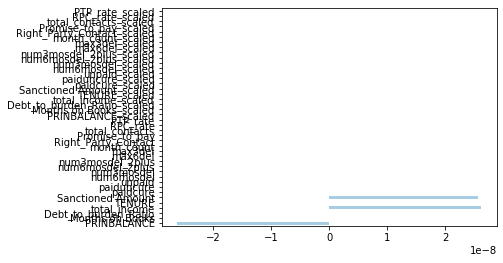

In [66]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], X_train.columns)
feature_importance.plot.barh(cmap='Paired')

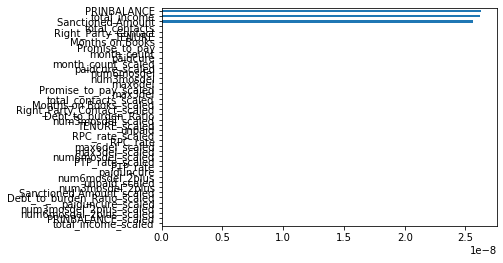

In [67]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

In [68]:
X_train.columns

Index(['PRINBALANCE', 'Months on Books', 'Debt_to_burden_Ratio',
       'total_income', 'TENURE', 'Sanctioned Amount', 'paidcure', 'paiduncure',
       'unpaid', 'num6mosdel', 'num3mosdel', 'num6mosdel_2plus',
       'num3mosdel_2plus', 'max6del', 'max3del', 'month_count',
       'Right_Party_Contact', 'Promise_to_pay', 'total_contacts', 'RPC_rate',
       'PTP_rate', 'PRINBALANCE_scaled', 'Months on Books_scaled',
       'Debt_to_burden_Ratio_scaled', 'total_income_scaled', 'TENURE_scaled',
       'Sanctioned Amount_scaled', 'paidcure_scaled', 'paiduncure_scaled',
       'unpaid_scaled', 'num6mosdel_scaled', 'num3mosdel_scaled',
       'num6mosdel_2plus_scaled', 'num3mosdel_2plus_scaled', 'max6del_scaled',
       'max3del_scaled', 'month_count_scaled', 'Right_Party_Contact_scaled',
       'Promise_to_pay_scaled', 'total_contacts_scaled', 'RPC_rate_scaled',
       'PTP_rate_scaled'],
      dtype='object')

In [ ]:
columns = ['PRINBALANCE', 'total_income', 'Sanctioned Amount']

In [71]:
all_x = X_train[columns]
all_y = y_train

In [72]:
lr = LogisticRegression()
scores = cross_val_score(lr, all_x, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)

0.6398046499859109


In [74]:
lr = LogisticRegression()
lr.fit(all_x, all_y)
holdout_predictions = lr.predict(X_test[columns])

In [75]:
# lr = LogisticRegression()
# lr.fit(X_train, all_y)
# predictions = lr.predict(X_test)
accuracy = accuracy_score(y_test, holdout_predictions)
print(accuracy)

0.6455078125


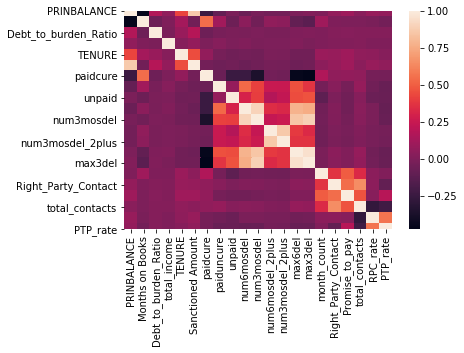

In [76]:
import seaborn as sns
correlations = all_x.corr()
sns.heatmap(correlations)
plt.show()

In [77]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

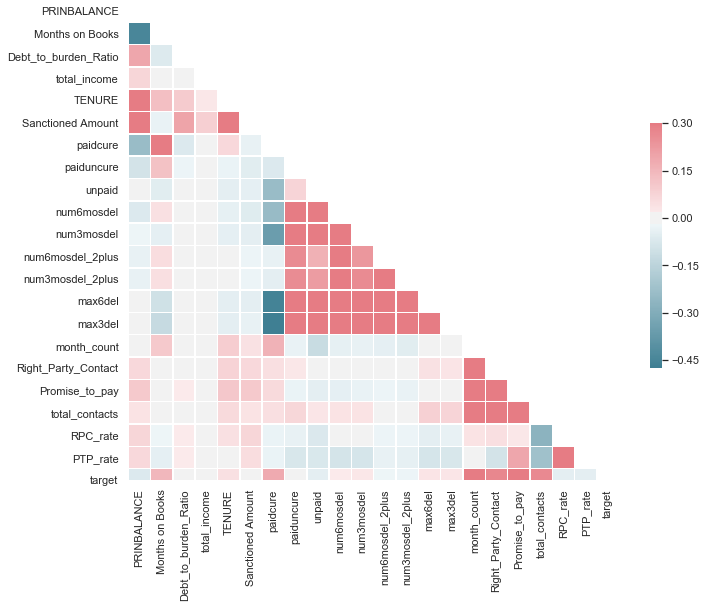

In [85]:
df_corr = dataframe.corr
plot_correlation_heatmap(dataframe)

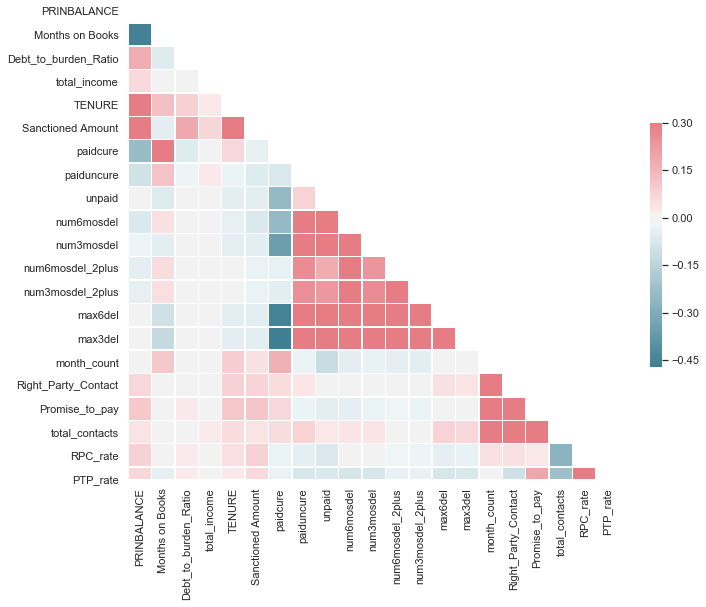

In [78]:
correlations = all_x[columns].corr
plot_correlation_heatmap(all_x[columns])

In [82]:
from sklearn.feature_selection import RFECV

lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_x,all_y)

optimized_columns = all_x.columns[selector.support_]

In [83]:
optimized_columns

Index(['total_income'], dtype='object')

In [47]:
import time
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
XGB_Accuracy = accuracy_score(y_test, preds)
XGB_AUC = roc_auc_score(y_test, preds)

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time)) 
print("AUC: " + str(XGB_AUC))


XGBoost's prediction accuracy is: 94.11
Time consumed for training: 1.102
Time consumed for prediction: 0.02634 seconds
AUC: 0.9503212141088636


In [51]:
RFC_Model = RandomForestClassifier()
RFC_Model.fit(X_train, y_train)
RFC_Predict = RFC_Model.predict(X_test)
RFC_Accuracy = accuracy_score(y_test, RFC_Predict)
print("Accuracy: " + str(RFC_Accuracy))

RFC_AUC = roc_auc_score(y_test, RFC_Predict) 
print("AUC: " + str(RFC_AUC))

Accuracy: 0.9421574519230769
AUC: 0.9518523469836907


In [52]:
#Logistic Regression
LR_Model = LogisticRegression()
training_start2 = time.perf_counter()
LR_Model.fit(X_train, y_train)
training_end2 = time.perf_counter()
prediction_start2 = time.perf_counter()
preds = LR_Model.predict(X_test)
prediction_end2 = time.perf_counter()
acc_LR = (preds == y_test).sum().astype(float) / len(preds)*100
LR_train_time = training_end2-training_start2
LR_prediction_time = prediction_end2-prediction_start2
LR_Accuracy = accuracy_score(y_test, preds)
LR_AUC = roc_auc_score(y_test, preds)

print("LR's prediction accuracy is: %3.2f" % (acc_LR))
print("Time consumed for training: %4.3f" % (LR_train_time))
print("Time consumed for prediction: %6.5f seconds" % (LR_prediction_time)) 
print("AUC: " + str(LR_AUC))

LR's prediction accuracy is: 64.55
Time consumed for training: 0.064
Time consumed for prediction: 0.00161 seconds
AUC: 0.5


In [53]:
print(xgb.feature_importances_)
print(RFC_Model.feature_importances_)


[0.00378651 0.00306394 0.0023139  0.00227875 0.00247637 0.00217809
 0.00227092 0.00239556 0.00298646 0.00252683 0.00793218 0.00315364
 0.00279523 0.         0.         0.9480186  0.00189721 0.00257675
 0.00211155 0.00263328 0.00260418]
[3.99099517e-02 3.35350776e-02 3.62200088e-02 3.35318184e-02
 6.02268172e-03 2.51415748e-02 1.07871999e-02 1.36506778e-03
 3.13403320e-03 5.28696344e-03 5.21338635e-03 4.57031482e-04
 3.59341134e-04 2.03928286e-03 3.72200490e-03 5.23750202e-01
 8.39363311e-02 4.67710006e-02 7.62521297e-02 2.98430760e-02
 3.27218363e-02]
